## Outline   
(1) Pipeline   
(2) Cross validation   
(3) Grid search, random search for hyperparameter tuning
(4) Learning curve, validation curve   
(5) Various metrics (confusion matrix, precision, recall, ROC, matthew correlation coefficient)   
(6) Sampling from imbalanced data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import scipy

from sklearn.model_selection import RandomizedSearchCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import make_scorer

from sklearn.metrics import roc_curve, auc

from sklearn.utils import resample

In [2]:
# Load the Breast Cancer Wisconsin Dataset
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)
# There is no column labels in the data, so header=None is required. Otherwise, the first row would be treated as column labels.

In [3]:
df.rename(columns={0:"ID", 1:"Diagnoses"})
# The first column stores the IDs of the patients.
# The second column stores the diagnoses of the patients: malignant(M), benign(B)

,ID,Diagnoses,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [4]:
# Extract feature values and class labels
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

In [5]:
# Transform the class labels (strings) to integers
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
# To see the relation between the new labels and the old ones:
print(le.classes_) # This shows all possible old class labels
print(le.transform(['B', 'M'])) # This shows how to transform an old label to a new one: $B->0$, $M->1$

['B' 'M']
[0 1]


In [7]:
# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [8]:
# Pipeline implementation of normalization, PCA, linear regression
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

In [9]:
# Accuracy of prediction
# This is the ratio between #corrected predictions and #all test examples.
test_acc = pipe_lr.score(X_test, y_test)
print("Test accuracy:", test_acc)

Test accuracy: 0.956140350877193


In [10]:
# Step-by-step implementation
# An advantage of this implementation is that we can get the principal components for visualization.

# Standardization
# Create a scaler
stdsc = StandardScaler()
# Fit and transform the training set
X_train_std = stdsc.fit_transform(X_train)
# Transform the testing set with the same scaler
X_test_std = stdsc.transform(X_test)

In [11]:
# PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [12]:
# Logistic regression
lr = LogisticRegression(random_state=1, solver='lbfgs')
lr.fit(X_train_pca, y_train)

LogisticRegression(random_state=1)

In [13]:
# Visualization
# Provide the testing data together with the original data.
def plot_decision_regions2(X, y, classifier, resolution=0.02, circle_test=False, X_test=None):
    # Create lists of markers and colors
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    
    # np.unique: find the unique elements of an array
    # The output y only has two possible values, 0 and 1. Therefore np.unique(y) is 2.
    # Then colors[:len(np.unique(y))] is colors[:2], i.e., colors = ('red', 'blue')
    # This is suitable for discrete colors.
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Set the range 
    # The range of the figure is larger than the range of the features.
    # Prevent data points from lying on the edges of the figure.
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1 
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1 
    # Generate meshgrid
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    # np.ravel(): flatten an array. It returns a 1D-array
    # The input of the function 'predict' is X. Each column of X corresponds to a feature.
    # Therefore, after raveling, we need to transpose the array.
    # lab: labels for all grid points
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # The output of 'predict' is a 1D-array. It is reshaped to have the same shape as xx1
    lab = lab.reshape(xx1.shape)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    # alpha: control the transparency
    ax.contourf(xx1, xx2, lab, alpha=0.2, cmap=cmap)
    
    # Plot training examples
    # enumerate: 
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y==cl,0], y=X[y==cl,1], alpha=1, c=colors[idx], marker=markers[idx], label='Class {}'.format(cl), edgecolor="black")
    
    if circle_test:
        # Circle testing examples
        ax.scatter(x=X_test[:,0], y=X_test[:,1], alpha=1, c='none', marker='o', label='Test set', edgecolor="black", linewidth=1, s=100)
        # s: marker size
    
    ax.legend()

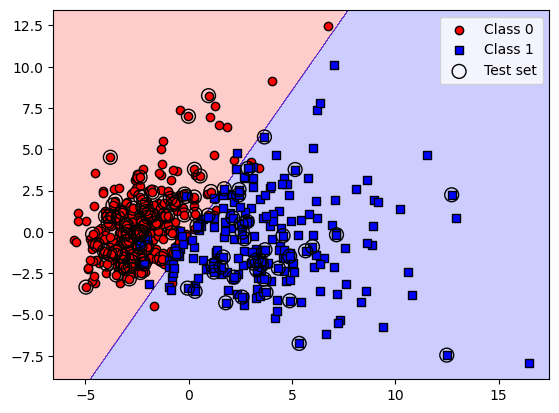

In [14]:
# Plot all examples and circle the testing data
# Put X_train_pca above X_test_pca
X_pca = np.concatenate((X_train_pca, X_test_pca), axis=0)
# We cannot use y directly, because its order is not the same as X_train_pca and X_test_pca
# Therefore, we concatenate y_train, y_test
y_pca = np.concatenate((y_train, y_test))

# Plot
plot_decision_regions2(X_pca, y_pca, classifier=lr, circle_test=True, X_test=X_test_pca)

# Cross validation

## Holdout method   
(1) Divide the data into a training set, a validation set, and a test set.   
(2) The model to be trained include hyperparameters, such as regularization strength. For given hyperparameter values, we train the model using the training set. Then evaluate the model with the validation set. A measure of performance should be defined at this step.    
(3) We change the hyperparameters, and train and evaluate the model again. Then we select the parameter values corresponding to the best performance.   
(4) Finally, we estimate the model's performance with the test set.

## k-fold cross validation   
The description in the book is confusing. Here is my understanding:   
(1) Divide the data into a training set and a test set.   
(2) Use the training set to do cross validation. The training set is divided into k folds. We train the model with each k-1 folds, and use the rest fold to evaluate the performance. After k rounds, there are k evaluations. These evaluations are then averaged. This average is the performance corresponding to a single set of hyperparameter values. Then we change the parameter values and repeat the procedure.  
(3) Finally, after we select the best hyperparameter values. We fit the model to the whole training data and get a final evaluation with the test set.

## Stratified k-fold cross-validation
Make each fold have the same class proportions as the whole data set.

In [15]:
# Stratified k-fold cross-validation
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
# This is a compound notation. A step-by-step implementation is:
# skf = StratifiedKFold(n_splits=10)
# skf.split(X_train, y_train)

In [16]:
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test],y_train[test])
    # Note that the score actually belongs to the classifier in the pipeline.
    # In this case, it is logistic regression.
    scores.append(score)
    print(f'Fold:{k+1:02d}', f'Class distribution:{np.bincount(y_train[train])}', f'Accuracy:{score:.3f}')
    
# f'...' is a way to format a string.
# Basic format: f'..{variable}..'.
# To specify the format of the variable: f'..{variable:format}..'

Fold:01 Class distribution:[256 153] Accuracy:0.935
Fold:02 Class distribution:[256 153] Accuracy:0.935
Fold:03 Class distribution:[256 153] Accuracy:0.957
Fold:04 Class distribution:[256 153] Accuracy:0.957
Fold:05 Class distribution:[256 153] Accuracy:0.935
Fold:06 Class distribution:[257 153] Accuracy:0.956
Fold:07 Class distribution:[257 153] Accuracy:0.978
Fold:08 Class distribution:[257 153] Accuracy:0.933
Fold:09 Class distribution:[257 153] Accuracy:0.956
Fold:10 Class distribution:[257 153] Accuracy:0.956


In [17]:
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f"Accuracy: {mean_acc:.4f} +/- {std_acc:.4f}")

Accuracy: 0.9495 +/- 0.0139


In [18]:
# use sklearn to get the scores
scores_sklearn = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print(f"Accuracy: {scores_sklearn}")

# n_jobs: number of jobs to run in parallel. Training the estimator and computing the score are parallelized over the cross-validation splits.
# cv: number of folds

mean_acc = np.mean(scores_sklearn)
std_acc = np.std(scores_sklearn)
print(f"Accuracy: {mean_acc:.4f} +/- {std_acc:.4f}")

Accuracy: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
Accuracy: 0.9495 +/- 0.0139


In [67]:
# Learning curve from sklearn
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', max_iter=10000))

train_sizes, train_scores, test_scores = \
            learning_curve(estimator=pipe_lr, 
                           X=X_train, y=y_train, 
                           train_sizes=np.linspace(0.1, 1.0, 10),
                           cv=5,
                           n_jobs=1
                          )

# train_sizes: learning_curve fits the model to data sets of increasing size.
# The number of examples in each set is specified by train_sizes.
# We can use a list of integers to specify the number of examples, such as train_sizes=[10, 20, 30].
# Or we can use relative sizes as shown above. train_sizes=np.linspace(0.1, 1.0, 10) means that ten data sets are used.
# They contain 10%, 20%, ... 100% of the whole data.
# cv=5: for each data set, a 5-fold cross-validation is performed.
# For example, the first set contains 10% data, and it is further splitted into 10 folds.

# train_sizes: the numbers of examples in the data sets. It is an array of integers.
# train_scores: for each data set, 5-fold cross-validation is performed. Thus, there are 5 scores for the predictions on the training set (5 folds)
#               so currently there are 10 rows and 5 columns
# test_scores: There are 10 scores for the predictions on the training set (1 folds)

# ?? Question: when the training size is, say, 0.4, are these examples randomly sampled from the original data?

In [20]:
# Calculate the mean and standard deviation for each round of training
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)


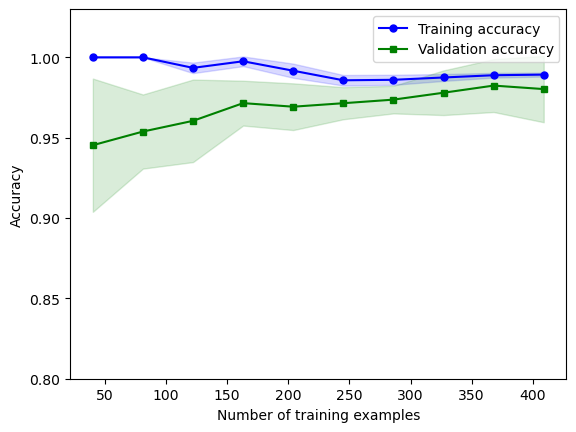

In [21]:
# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(train_sizes, train_mean, color="blue", marker="o", markersize=5, label="Training accuracy")
ax.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color="blue")

ax.plot(train_sizes, test_mean, color="green", marker="s", markersize=5, label="Validation accuracy")
ax.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color="green")

ax.set_xlabel("Number of training examples")
ax.set_ylabel("Accuracy")

ax.set_ylim([0.8, 1.03])
ax.legend()

In [22]:
# Validation curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train, y=y_train, 
                                             param_name="logisticregression__C",
                                             param_range=param_range,
                                             cv=10
                                            )

In [23]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

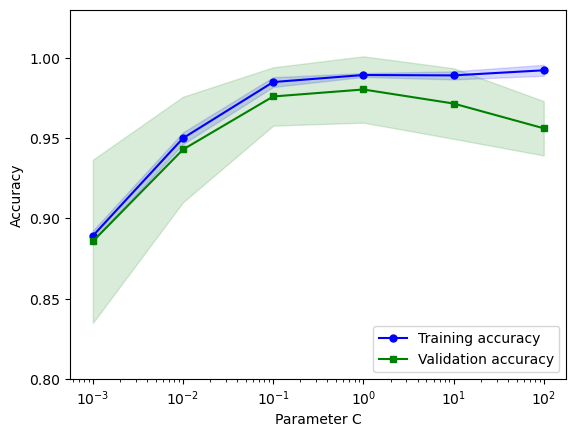

In [24]:
# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(param_range, train_mean, color="blue", marker="o", markersize=5, label="Training accuracy")
ax.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color="blue")


ax.plot(param_range, test_mean, color="green", marker="s", markersize=5, label="Validation accuracy")
ax.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color="green")

ax.set_xlabel("Parameter C")
ax.set_ylabel("Accuracy")

ax.set_xscale('log')

ax.set_ylim([0.8, 1.03])
ax.legend(loc="lower right")

## Grid search to tune hyperparameters

In [25]:
# Initialize a pipeline for svc classifier
pipe_scv = make_pipeline(StandardScaler(), SVC(random_state=1))
# Define the parameter range to be iterated over.
param_range = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
# Define parameter grid
# Note that the type of kernel is also a hyperparameter
param_grid = [
    {'svc__C':param_range,
     'svc__kernel':['linear']
    },
    {'svc__C':param_range,
     'svc__gamma':param_range,
     'svc__kernel':['rbf']
    }
]
# Initialize a grid search agent
gs = GridSearchCV(estimator=pipe_scv,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True    
)

About SVC:   
(1) This is a support vector machine classifier with kernel.   
(2) It has a parameter C: the regularization strength is inversely proportional to C.   
(3) gamma: kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.   
rbf: $$\exp(-\gamma||x-x'||^2)$$
For ‘poly’ and ‘sigmoid’, $\gamma$ has different meanings.   
(4) random_state：“Controls the pseudo random number generation for shuffling the data for probability estimates.” （Cannot understand）   
(5) Note that in the above pipeline, C and gamma are not specified. The values of these parameters, including the kernel types,  are searched by grid.

In [26]:
# Grid search
gs = gs.fit(X_train, y_train)

In [27]:
print(gs.best_score_)

0.9846859903381642


In [28]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [29]:
# Test the best selected model
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f"Test accuracy: {clf.score(X_test, y_test)}")

Test accuracy: 0.9736842105263158


In [30]:
# The best estimator is a pipeline whose parameters are specified according to the grid search.
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=0.001, random_state=1))])

In [31]:
# Since the parameter refit is set to be True in GridSearchCV, we don't have to fit the best estimator manaully to X_train and y_train.
# The following codes still work, withough "clf.fit(X_train, y_train)"
clf = gs.best_estimator_
print(f"Test accuracy: {clf.score(X_test, y_test)}")

Test accuracy: 0.9736842105263158


## Randomized search

In [32]:
# Randomized search

# Here is the parameter range used in the grid search:
# param_range = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

# For randomized search, we specify distribution
param_distr = scipy.stats.loguniform(1e-4, 1e3) # The two parameters here specify the shape of the distribution.
# Using the log uniform instead of the uniform ensures that each order of magnitude can be sampled with the same number of examples.

# Check the behavior of the distribution
np.random.seed(1) # I guess this code is to ensure repeatable result.
print(param_distr.rvs(10)) # Generate 10 random samples

[8.30145146e-02 1.10222804e+01 1.00184520e-04 1.30715777e-02
 1.06485687e-03 4.42965766e-04 2.01289666e-03 2.62376594e-02
 5.98924832e-02 5.91176467e-01]


In [33]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# This is similar to the grid search, but the parameter range is replaced by the distribution.
param_grid = [
    {'svc__C':param_distr,
     'svc__kernel':['linear']
    },
    {'svc__C':param_distr,
     'svc__gamma':param_distr,
     'svc__kernel':['rbf']
    }
]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1
                       )

# n_iter: number of parameter combinations sampled. 

In [34]:
rs = rs.fit(X_train, y_train)

In [35]:
print(rs.best_score_)

0.9780676328502416


In [36]:
print(rs.best_params_)

{'svc__C': 0.05971247755848464, 'svc__kernel': 'linear'}


## Successive halving

In [37]:
hs = HalvingRandomSearchCV(pipe_svc,
                           param_distributions=param_grid,
                           n_candidates='exhaust',
                           resource='n_samples',
                           factor=1.5,
                           random_state=1,
                          )

# The book does not explain this method in detail. 
# Here is a rough description of the parameters:
# factor: 1/factor examples will make it into the next round.
# resource='n_samples': increase the size the training data at each iteration
# n_candidate='exhaust': in the last round, all training data will be used.

In [38]:
hs = hs.fit(X_train, y_train)

In [39]:
print(hs.best_score_)

0.9617647058823529


In [40]:
print(hs.best_params_)

{'svc__C': 4.934834261073341, 'svc__kernel': 'linear'}


In [41]:
clf = hs.best_estimator_
print(f'Test accuracy: {hs.score(X_test, y_test)}')

Test accuracy: 0.9824561403508771


## Nested cross validation   
(1) Split the data into k folds.   
(2) For each k-1 folds, use them as training data, and the rest k fold as testing data.   
(3) For the training data, further split it into l folds and use l-fold cross validation to train the model.   
(4) The testing data is used to evaluate the performance of the model.   


In sum, the outer k-fold cv splits the data into training and testing data sets, rather than training and validation sets.

In [42]:
param_range = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

param_grid = [
    {'svc__C':param_range,
     'svc__kernel':['linear']
    },
    {'svc__C':param_range,
     'svc__gamma':param_range,
     'svc__kernel':['rbf']
    }
]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2
                 )

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores)} +/- {np.std(scores)}')


CV accuracy: 0.9736263736263737 +/- 0.014906219743132467


In [43]:
# Nested cross validation for decision tree.
gs = GridSearchCV(
                    estimator=DecisionTreeClassifier(random_state=0),
                    param_grid=[{'max_depth': [1,2,3,4,5,6,7,None]}],
                    scoring='accuracy',
                    cv=2
)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores)} +/- {np.std(scores)}')

CV accuracy: 0.9340659340659341 +/- 0.015540808377726326


## Other evaluation metrics

Confusion matrix

In [44]:
# Train a support vector machine classifier.
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
pipe_svc.fit(X_train, y_train)

# Obtain the confusion matrix
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


In [45]:
confmat[1,0]

2

Text(0, 0.5, 'True label')

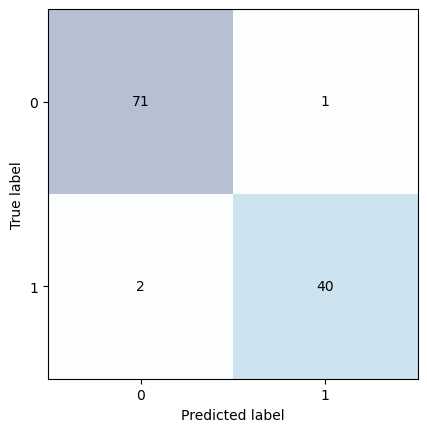

In [46]:
# Visualization of the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3) #???cmap=plt.cm.Blues

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center') #meaning of va and ha????
        # Note that there is a trick here. The entry confmat[i,j] should be placed at (j,i)
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
    

## Precision, Recall, Matthews Correlation Coefficient

In [47]:
# Sklearn implementation of various metrics
pre_val = precision_score(y_true=y_test, y_pred=y_pred)
rec_val = recall_score(y_true=y_test, y_pred=y_pred)
f1_val = f1_score(y_true=y_test, y_pred=y_pred)
mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)

print(f'Precision: {pre_val}')
print(f'Recall: {rec_val}')
print(f'f1 score: {f1_val}')
print(f'MCC: {mcc_val}')

Precision: 0.975609756097561
Recall: 0.9523809523809523
f1 score: 0.963855421686747
MCC: 0.9433397594898876


In [48]:
# Use one of the above metrics in grid search
# Use a user-defined score
c_gamma_range = [1e-2, 1e-1, 1, 1e1]
param_grid = [
    {
        'svc__C': c_gamma_range,
        'svc__kernel': ['linear']
    },
    {
        'svc__C': c_gamma_range,
        'svc__gamma': c_gamma_range,
        'svc__kernel': ['rbf']
    }
]

# Define the score to be f1_score, and the positive label is 0
scorer = make_scorer(f1_score, pos_label=0)


pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)

In [49]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(random_state=1))]),
             param_grid=[{'svc__C': [0.01, 0.1, 1, 10.0],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.01, 0.1, 1, 10.0],
                          'svc__gamma': [0.01, 0.1, 1, 10.0],
                          'svc__kernel': ['rbf']}],
             scoring=make_scorer(f1_score, pos_label=0))

In [50]:
print(gs.best_score_)

0.9861994953378878


In [51]:
print(gs.best_params_)

{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## Receiver operating characteristic (ROC)

In [52]:
# Initiate a logistic regression pipeline
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', C=100.0)
)

In [53]:
# Extract two columns
X_train2 = X_train[:, [4, 14]]

In [54]:
pipe_lr.fit(X_train2, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression',
                 LogisticRegression(C=100.0, random_state=1))])

In [55]:
# The pipe_lr.classes_ attribute stores class labels
pipe_lr.classes_

array([0, 1])

In [56]:
# pipe_lr.predict_proba predicts the probabilities of each class. Of course, they sum up to 1.
# The probabilities are ordered according to pipe_lr.classes_
# Since the list is long, only the probabilities for the first 5 test examples are shown.
pipe_lr.predict_proba(X_test[:, [4, 14]])[:5,:]

array([[0.5567139 , 0.4432861 ],
       [0.66041769, 0.33958231],
       [0.87734244, 0.12265756],
       [0.57465886, 0.42534114],
       [0.9766929 , 0.0233071 ]])

In [57]:
# cross validation
skf = StratifiedKFold(n_splits=3)
cv = list(skf.split(X_train, y_train)) #??? Do we need to turn it into a list? Can't we use directly?
# skf.split(X_train, y_train): this gives an enumerator
# If we turn it into a list, we will see that it has 3 entries. This coincides with the number of folds.
# Each entry is a 2-tuple. The first entry of the tuple is a 1D numpy array, which stores the indices of the training examples.
# The second entry of the tuple is another 1D numpy array which stores the indices of the test examples.

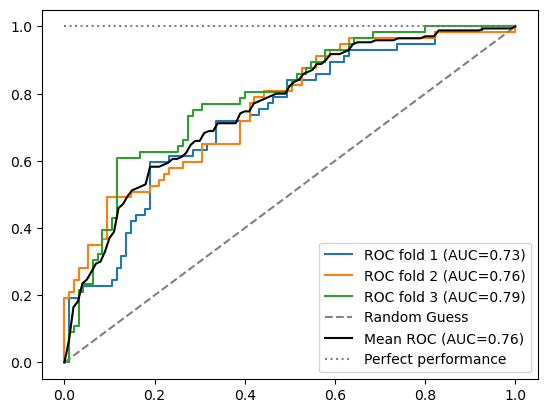

In [58]:
mean_tpr = 0.0


x_list = np.linspace(0, 1, 101) # In the original code, this is names as mean_fpr. 
#But it does not store means. It only stores the locations where the means are taken.

fig = plt.figure()
ax = fig.add_subplot(111)

for i, (train, test) in enumerate(cv):
    # Fit the model to the current split of data
    pipe_lr.fit(X_train2[train], y_train[train])
    # We use the predicted probabilities on the test fold to construct an ROC curve
    probas = pipe_lr.predict_proba(X_train2[test])
    # Calculate the FPR, TPR, and the corresponding thresholds
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1], pos_label=1) # We only need class 1 probabilities.
    # Calculate auc
    roc_auc = auc(fpr, tpr)
    # Plot ROC
    ax.plot(fpr, tpr, label=f'ROC fold {i+1} (AUC={roc_auc:.2f})')
    
    # Summation for a mean ROC curve
    mean_tpr += np.interp(x_list, fpr, tpr)
    # np.interp: linear interpolation. 
    # The original data points are given by fpr and tpr
    # The desired function value of the interpolation function are at x_list
    
ax.plot([0,1],[0,1], linestyle="dashed", color="gray", label='Random Guess')

mean_tpr /= len(cv)
mean_tpr[0] = 0
mean_tpr[-1] = 1
mean_auc = auc(x_list, mean_tpr)
ax.plot(x_list, mean_tpr, color="black", label=f'Mean ROC (AUC={mean_auc:.2f})')


ax.plot([0,1],[1,1], linestyle=":", color="gray", label='Perfect performance')

    
    
ax.legend()
    

## Imbalanced data

In [59]:
# Create an imbalanced data set
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

In [60]:
# One solution to deal with imbalanced data is to resample from a minority class
print('Number of class 1 examples before resampling:', X_imb[y_imb==1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb==1], y_imb[y_imb==1], 
                                    replace=True, n_samples=X_imb[y_imb==0].shape[0], random_state=1)
print('Number of class 1 examples after resampling:', X_upsampled.shape[0])

Number of class 1 examples before resampling: 40
Number of class 1 examples after resampling: 357


In [61]:
# Create a balanced data set
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))